# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import pandas as pd
import boto3
from io import BytesIO
import pandas as pd
import os


# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [2]:


# Загрузка данных
tracks = pd.read_parquet('tracks.parquet')
catalog_names = pd.read_parquet('catalog_names.parquet')
interactions = pd.read_parquet('interactions.parquet')

# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [ ]:
print(tracks.info())
print(tracks.isnull().sum())
print(tracks['track_id'].nunique() == len(tracks))

In [ ]:
print(catalog_names.info())
print(catalog_names.isnull().sum())
print(catalog_names.groupby('type')['id'].nunique())

In [ ]:
print(interactions.info())
print(interactions.isnull().sum())
print(interactions.duplicated(subset=['user_id', 'track_id']).sum())

# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

In [ ]:
# Группируем по пользователям и считаем количество прослушиваний
user_plays = interactions.groupby('user_id').size().reset_index(name='tracks_played')
distribution = user_plays['tracks_played'].describe(percentiles=[.25, .5, .75, .9, .95, .99])
print("Распределение количества прослушанных треков:")
print(distribution)

Наиболее популярные треки

In [ ]:
# Считаем количество прослушиваний для каждого трека
track_popularity = interactions.groupby('track_id').size().reset_index(name='plays')
top_tracks = track_popularity.sort_values('plays', ascending=False).head(10)
print("\nТоп-10 популярных треков:")
print(top_tracks)

Наиболее популярные жанры

In [8]:

track_genres = tracks.set_index('track_id')['genres'].to_dict()



In [9]:

track_plays = interactions['track_id'].value_counts().reset_index()
track_plays.columns = ['track_id', 'plays']

In [10]:
from collections import defaultdict 

genre_plays = defaultdict(int)

In [11]:

for track_id, plays in track_plays.itertuples(index=False):
    genres = track_genres.get(track_id, [])
    for genre_id in genres:
        genre_plays[genre_id] += plays

In [12]:

genre_popularity = (
    pd.DataFrame(list(genre_plays.items()), columns=['genre_id', 'plays'])
    .sort_values('plays', ascending=False)
    .head(10)
)

In [ ]:

genre_names = (
    catalog_names[catalog_names['type'] == 'genre']
    .set_index('id')['name']
    .to_dict()
)

genre_popularity['genre_name'] = genre_popularity['genre_id'].map(genre_names)

print("Топ-10 популярных жанров:")
print(genre_popularity[['genre_name', 'plays']])

Треки, которые никто не прослушал

In [ ]:
# Находим треки из каталога, отсутствующие в прослушиваниях
unplayed_tracks = tracks[~tracks['track_id'].isin(interactions['track_id'])][['track_id']]
print("\nТреки без прослушиваний:")
print(unplayed_tracks)

# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [ ]:
# Извлечение названий треков
track_names = catalog_names[catalog_names['type'] == 'track'][['id', 'name']]
track_names = track_names.rename(columns={'id': 'track_id', 'name': 'track_name'})

# Извлечение названий альбомов
album_names = catalog_names[catalog_names['type'] == 'album'][['id', 'name']]
album_names = album_names.rename(columns={'id': 'album_id', 'name': 'album_name'})

# Извлечение названий артистов
artist_names = catalog_names[catalog_names['type'] == 'artist'][['id', 'name']]
artist_names = artist_names.rename(columns={'id': 'artist_id', 'name': 'artist_name'})

# Извлечение названий жанров
genre_names = catalog_names[catalog_names['type'] == 'genre'][['id', 'name']]
genre_names = genre_names.rename(columns={'id': 'genre_id', 'name': 'genre_name'})

# Объединение данных
items = (
    tracks
    # Добавление названий треков
    .merge(track_names, on='track_id', how='left')
    
    # Развертывание списков альбомов
    .explode('albums')
    .rename(columns={'albums': 'album_id'})
    # Добавление названий альбомов
    .merge(album_names, on='album_id', how='left')
    
    # Развертывание списков артистов
    .explode('artists')
    .rename(columns={'artists': 'artist_id'})
    # Добавление названий артистов
    .merge(artist_names, on='artist_id', how='left')
    
    # Развертывание списков жанров
    .explode('genres')
    .rename(columns={'genres': 'genre_id'})
    # Добавление названий жанров
    .merge(genre_names, on='genre_id', how='left')
    
    # Группировка в списки
    .groupby(['track_id', 'track_name']).agg({
        'album_id': list,
        'album_name': list,
        'artist_id': list,
        'artist_name': list,
        'genre_id': list,
        'genre_name': list
    }).reset_index()
)

# Проверка результата
print(items.head(3))

# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [16]:
events = interactions.copy()

In [ ]:
%load_ext autoreload
%autoreload 2
from dotenv import load_dotenv, find_dotenv
import os

In [ ]:
# подгружаем .env
load_dotenv()

In [19]:
s3_bucket = os.environ.get('S3_BUCKET_NAME')
s3_access_key = os.environ.get('AWS_ACCESS_KEY_ID')
s3_secret_access_key = os.environ.get('AWS_SECRET_ACCESS_KEY')

In [ ]:
print(s3_access_key)

In [ ]:
import os
import boto3
import pandas as pd
from io import BytesIO

AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
BUCKET_NAME = os.getenv("S3_BUCKET_NAME")

required_vars = {
    "AWS_ACCESS_KEY_ID": AWS_ACCESS_KEY_ID,
    "AWS_SECRET_ACCESS_KEY": AWS_SECRET_ACCESS_KEY,
    "S3_BUCKET_NAME": BUCKET_NAME
}

missing = [var for var, val in required_vars.items() if not val]
if missing:
    raise ValueError(f"Отсутствуют переменные окружения: {', '.join(missing)}")

os.environ.update({
    "MLFLOW_S3_ENDPOINT_URL": "https://storage.yandexcloud.net",
    "AWS_ACCESS_KEY_ID": AWS_ACCESS_KEY_ID, 
    "AWS_SECRET_ACCESS_KEY": AWS_SECRET_ACCESS_KEY,
})

# Инициализация клиента S3
s3 = boto3.client(
    's3',
    endpoint_url="https://storage.yandexcloud.net",  
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY
)

def save_df_to_s3_parquet(df, bucket, key):
    """Сохраняет DataFrame в Parquet на S3"""
    if not isinstance(df, pd.DataFrame):
        raise TypeError("df должен быть pandas DataFrame")
    
    buffer = BytesIO()
    df.to_parquet(buffer, index=False)
    buffer.seek(0)
    
    s3.put_object(
        Bucket=bucket,
        Key=key,
        Body=buffer,
        ContentType='application/parquet'
    )
    print(f"Файл {key} успешно загружен в S3")

try:
    save_df_to_s3_parquet(items, BUCKET_NAME, 'recsys/data/items.parquet')
    save_df_to_s3_parquet(events, BUCKET_NAME, 'recsys/data/events.parquet')
    print("Все файлы успешно загружены в S3!")
    
except Exception as e:
    print(f"Ошибка при загрузке в S3: {str(e)}")
    print(f"BUCKET_NAME: {BUCKET_NAME}")
    print(f"Ключ доступа: {AWS_ACCESS_KEY_ID[:5]}...") 
    print(f"Тип данных items: {type(items)}")
    print(f"Тип данных events: {type(events)}")

In [22]:

items.to_parquet("items.parquet")
events.to_parquet("events.parquet")

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

In [ ]:
import gc
gc.collect()

print("Память частично освобождена")


# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime

# Загрузка обработанных данных
items = pd.read_parquet('/home/mle-user/mle-project-sprint-4-v001/items.parquet')
events = pd.read_parquet('/home/mle-user/mle-project-sprint-4-v001/events.parquet')

# Преобразование даты
events['started_at'] = pd.to_datetime(events['started_at'])

# Разделение данных
train_events = events[events['started_at'] < datetime(2022, 12, 16)]
test_events = events[events['started_at'] >= datetime(2022, 12, 16)]

# Сохранение тестовых данных для оценки
test_events.to_parquet('test_events.parquet', index=False)

# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [4]:
# Расчет популярности треков
top_popular = (
    train_events.groupby('track_id')
    .size()
    .reset_index(name='count')
    .sort_values('count', ascending=False)
    .head(1000)  # Топ-1000 популярных треков
)

# Сохранение результатов
top_popular.to_parquet('top_popular.parquet', index=False)

# Персональные

Рассчитаем персональные рекомендации.

In [5]:
from implicit.als import AlternatingLeastSquares
import scipy.sparse as sp
import numpy as np
import pandas as pd

# Ограничение датасета: выбираем топ-N пользователей по количеству взаимодействий
USER_LIMIT = 10000  # Уменьшите для ускорения

# Фильтрация активных пользователей
user_activity = train_events['user_id'].value_counts()
selected_users = user_activity.head(USER_LIMIT).index
train_events_limited = train_events[train_events['user_id'].isin(selected_users)].copy()

# Пересоздаем отображения для ограниченного датасета
user_ids = train_events_limited['user_id'].unique()
track_ids = train_events_limited['track_id'].unique()

user2idx = {user: idx for idx, user in enumerate(user_ids)}
track2idx = {track: idx for idx, track in enumerate(track_ids)}
idx2user = {idx: user for user, idx in user2idx.items()}
idx2track = {idx: track for track, idx in track2idx.items()}

# Строим матрицу взаимодействий
rows = train_events_limited['user_id'].map(user2idx)
cols = train_events_limited['track_id'].map(track2idx)
values = np.ones(len(train_events_limited))

user_item_matrix = sp.csr_matrix(
    (values, (rows, cols)), 
    shape=(len(user_ids), len(track_ids))
)

# Уменьшаем параметры модели для ускорения
model = AlternatingLeastSquares(
    factors=32,           # Уменьшено с 64
    regularization=0.05,
    iterations=10,        # Уменьшено с 15
    random_state=42,
    use_gpu=False        # Отключить GPU при проблемах
)
model.fit(user_item_matrix)

# Генерируем рекомендации только для ограниченного набора пользователей
user_indices = np.arange(len(user_ids))
recommendations = model.recommend(
    user_indices, 
    user_item_matrix,
    N=10,
    filter_already_liked_items=True
)

# Формируем результат
user_ids_arr = np.array([idx2user[i] for i in range(len(user_ids))])
track_ids_arr = np.array([idx2track[i] for i in range(len(track_ids))])

user_indices_flat = np.repeat(user_indices, 10)
user_ids_flat = user_ids_arr[user_indices_flat]
track_indices_flat = recommendations[0].flatten()
track_ids_flat = track_ids_arr[track_indices_flat]
scores_flat = recommendations[1].flatten()

personal_als = pd.DataFrame({
    'user_id': user_ids_flat,
    'track_id': track_ids_flat,
    'score': scores_flat
})

personal_als.to_parquet('personal_als.parquet', index=False)

/home/mle-user/.mle-sprint3-venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mle-user/.mle-sprint3-venv/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 10/10 [00:43<00:00,  4.37s/it]


# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [6]:
import concurrent.futures
import numpy as np

# Ограничиваем количество треков
TRACK_LIMIT = 5000

# Выбираем топ-N популярных треков
track_popularity = train_events_limited['track_id'].value_counts()
top_tracks = track_popularity.head(TRACK_LIMIT).index.tolist()

# Создаем эффективные отображения
track_indices = np.array([track2idx[track] for track in top_tracks])
idx2track_arr = np.array(list(idx2track.values()))  # Векторизованный доступ

# Кэшируем матрицу факторов для треков
track_factors = model.item_factors

# Функция для обработки одного трека
def process_track(track_idx):
    similar = model.similar_items(track_idx, N=6)  # Берем только 5 похожих + сам трек
    
    results = []
    for similar_idx, score in zip(similar[0][1:], similar[1][1:]):
        # Прямой доступ через массив вместо словаря
        similar_track_id = idx2track_arr[similar_idx]
        results.append((
            idx2track_arr[track_idx],  # original_track_id
            similar_track_id,
            score
        ))
    return results

# Многопоточная обработка
similar_items = []
with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
    futures = [executor.submit(process_track, tidx) for tidx in track_indices]
    for future in concurrent.futures.as_completed(futures):
        similar_items.extend(future.result())

# Создаем DataFrame и сохраняем
similar = pd.DataFrame(similar_items, columns=['original_track_id', 'similar_track_id', 'score'])
similar.to_parquet('similar.parquet', index=False)

# Построение признаков

In [7]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix


In [18]:

# 6. Признак 4: Общая активность пользователя
user_activity = train_events_limited.groupby('user_id').size().reset_index(name='total_activity')
base_df = base_df.merge(
    user_activity,
    on='user_id',
    how='left'
).fillna(0)

# 7. Признак 5: Средняя схожесть с историей прослушиваний
# Создаем словари схожести
similarity_dict = {}
for _, row in similar.iterrows():
    orig = row['original_track_id']
    sim = row['similar_track_id']
    score = row['score']
    if orig not in similarity_dict:
        similarity_dict[orig] = {}
    similarity_dict[orig][sim] = score

inverted_similarity = {}
for orig, sim_dict in similarity_dict.items():
    for sim, score in sim_dict.items():
        if sim not in inverted_similarity:
            inverted_similarity[sim] = {}
        inverted_similarity[sim][orig] = score

# Собираем историю прослушиваний
user_history = train_events_limited.groupby('user_id')['track_id'].apply(set).to_dict()

def calculate_avg_similarity(user_id, track_id):
    if user_id not in user_history:
        return 0.0
        
    user_tracks = user_history[user_id]
    total_sim = 0.0
    count = 0
    
    if track_id in inverted_similarity:
        track_similarities = inverted_similarity[track_id]
        for ut in user_tracks:
            if ut in track_similarities:
                total_sim += track_similarities[ut]
                count += 1
    
    return total_sim / count if count > 0 else 0.0

# Вычисляем для уникальных пар
unique_pairs = base_df[['user_id', 'track_id']].drop_duplicates()
unique_pairs['avg_sim'] = unique_pairs.apply(
    lambda row: calculate_avg_similarity(row['user_id'], row['track_id']), 
    axis=1
)

# Объединяем результаты
base_df = base_df.merge(
    unique_pairs,
    on=['user_id', 'track_id'],
    how='left'
)
base_df['avg_similarity'] = base_df['avg_sim'].fillna(0)
base_df.drop(columns=['avg_sim'], inplace=True)

# 8. Дополнительный признак: позиция в топе популярности
top_popular['popular_rank'] = top_popular['count'].rank(method='dense', ascending=False)
popular_rank_dict = top_popular.set_index('track_id')['popular_rank'].to_dict()
base_df['popular_rank'] = base_df['track_id'].map(popular_rank_dict).fillna(0)

# 9. Сохранение признаков
features = base_df[[
    'user_id', 'track_id', 'als_score', 'popularity', 
    'user_track_count', 'total_activity', 'avg_similarity',
    'popular_rank'
]]
features.to_parquet('ranking_features.parquet', index=False)

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

In [15]:
import lightgbm as lgb
from sklearn.model_selection import GroupShuffleSplit
import numpy as np
import pandas as pd


In [16]:
# 1. Загрузка и подготовка данных
features = pd.read_parquet('ranking_features.parquet')

# Создаем целевую переменную
features['target'] = (features['user_track_count'] > 0).astype(int)

In [19]:

# 2. Подготовка данных для LightGBM
# Для LambdaRank нам нужны группы пользователей
user_groups = features['user_id'].values
group_sizes = features.groupby('user_id').size().values


# Признаки и целевая переменная
X = features[['als_score', 'popularity', 'user_track_count', 
              'total_activity', 'avg_similarity', 'popular_rank']]
y = features['target']

In [20]:

# 3. Разделение данных с сохранением групповой структуры
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(X, y, groups=user_groups))

X_train = X.iloc[train_idx]
X_val = X.iloc[val_idx]
y_train = y.iloc[train_idx]
y_val = y.iloc[val_idx]

# Получаем размеры групп для тренировочных и валидационных данных
train_users = features.iloc[train_idx]['user_id'].unique()
val_users = features.iloc[val_idx]['user_id'].unique()

train_group_sizes = features[features['user_id'].isin(train_users)].groupby('user_id').size().values
val_group_sizes = features[features['user_id'].isin(val_users)].groupby('user_id').size().values


In [21]:


# 4. Создание Dataset для LightGBM
train_data = lgb.Dataset(
    X_train, 
    label=y_train,
    group=train_group_sizes,
    free_raw_data=False
)

val_data = lgb.Dataset(
    X_val, 
    label=y_val,
    group=val_group_sizes,
    reference=train_data,
    free_raw_data=False
)

In [22]:


# 5. Параметры модели
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'ndcg_eval_at': [10],
    'learning_rate': 0.05,
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'verbosity': -1,
    'seed': 42
}

In [25]:

# 6. Обучение модели с правильным использованием callbacks
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[val_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=20, verbose=True),
        lgb.log_evaluation(period=20)
    ]
)


Training until validation scores don't improve for 20 rounds
[20]	valid_0's ndcg@10: 1
Early stopping, best iteration is:
[1]	valid_0's ndcg@10: 1


In [27]:


# 7. Переранжирование рекомендаций
# Добавляем предсказания модели к данным
features['lgb_score'] = model.predict(X)


# Для каждого пользователя отбираем топ-10 рекомендаций
final_recs = features.sort_values(['user_id', 'lgb_score'], ascending=[True, False])
final_recs = final_recs.groupby('user_id').head(10)

# Сохранение финальных рекомендаций
final_recs[['user_id', 'track_id', 'lgb_score']].to_parquet('final_recommendations.parquet', index=False)

In [28]:


# 8. Вывод результатов
print("Ранжирующая модель успешно обучена!")
print(f"Количество пользователей: {len(final_recs['user_id'].unique())}")
print(f"Количество рекомендаций: {len(final_recs)}")

# Важность признаков
feature_importance = pd.DataFrame({
    'feature': model.feature_name(),
    'importance': model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

print("\nВажность признаков (по gain):")
print(feature_importance)

Ранжирующая модель успешно обучена!
Количество пользователей: 10000
Количество рекомендаций: 100000

Важность признаков (по gain):
            feature  importance
0         als_score         0.0
1        popularity         0.0
2  user_track_count         0.0
3    total_activity         0.0
4    avg_similarity         0.0
5      popular_rank         0.0


# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

In [3]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.metrics import precision_score, recall_score
import seaborn

In [4]:

# Загрузка данных
train_events = pd.read_parquet('/home/mle-user/mle-project-sprint-4-v001/events.parquet')
test_events = pd.read_parquet('test_events.parquet')
items = pd.read_parquet('/home/mle-user/mle-project-sprint-4-v001/items.parquet')


In [5]:

# 1. Подготовка тестовых данных
# Релевантные треки для каждого пользователя
test_relevant = test_events.groupby('user_id')['track_id'].apply(set).to_dict()

In [6]:

# 2. Загрузка рекомендаций
# Топ популярных
top_popular = pd.read_parquet('top_popular.parquet')
top10 = top_popular.head(10)['track_id'].tolist()

# ALS рекомендации
personal_als = pd.read_parquet('personal_als.parquet')

# Финальные рекомендации
final_recs = pd.read_parquet('final_recommendations.parquet')

In [8]:



# 3. Подготовка словарей рекомендаций
def prepare_recs(df, k=10):
    recs = {}
    for user, group in df.groupby('user_id'):
        # Сортируем по убыванию релевантности и берем топ-k
        recs[user] = group.sort_values('score' if 'score' in group.columns else 'lgb_score', 
                                      ascending=False)['track_id'].head(k).tolist()
    return recs

# Словари рекомендаций
top_recs = {user: top10 for user in test_relevant.keys()} 
als_recs = prepare_recs(personal_als)
final_recs_dict = prepare_recs(final_recs)


In [10]:

# 4. Метрики оценки

def calculate_recall(relevant_dict, recs_dict):
    """Вычисление Recall@10"""
    recalls = []
    for user, true_tracks in relevant_dict.items():
        if user not in recs_dict:
            continue
        pred_tracks = set(recs_dict[user][:10])
        true_positives = len(pred_tracks & set(true_tracks))
        if true_positives > 0:
            recalls.append(true_positives / min(10, len(true_tracks)))
    return np.mean(recalls) if recalls else 0

def calculate_precision(relevant_dict, recs_dict):
    """Вычисление Precision@10"""
    precisions = []
    for user, true_tracks in relevant_dict.items():
        if user not in recs_dict:
            continue
        pred_tracks = set(recs_dict[user][:10])
        true_positives = len(pred_tracks & set(true_tracks))
        precisions.append(true_positives / 10)
    return np.mean(precisions) if precisions else 0

def calculate_coverage(recs_dict, catalog_size):
    """Вычисление Coverage"""
    all_recs = set()
    for recs in recs_dict.values():
        all_recs.update(recs)
    return len(all_recs) / catalog_size

def calculate_novelty(recs_dict, popularity_dict):
    """Вычисление Novelty"""
    novelty_scores = []
    for recs in recs_dict.values():
        # Для каждого трека в рекомендациях: 1 / (популярность + 1)
        track_novelty = [1 / (popularity_dict.get(track, 0) + 1)for track in recs]
        novelty_scores.append(np.mean(track_novelty))
    return np.mean(novelty_scores) if novelty_scores else 0

In [11]:


# 5. Подготовка вспомогательных данных
# Размер каталога
catalog_size = len(items)

popularity_dict = train_events.groupby('track_id').size().to_dict()

In [12]:


# 6. Вычисление метрик для каждого типа рекомендаций
results = []

for rec_type, recs in [('Top Popular', top_recs), 
                      ('ALS', als_recs), 
                      ('Final', final_recs_dict)]:
    
    # Фильтруем пользователей, для которых есть рекомендации
    common_users = set(recs.keys()) & set(test_relevant.keys())
    filtered_recs = {user: recs[user] for user in common_users}
    
    # Вычисляем метрики
    recall = calculate_recall(test_relevant, filtered_recs)
    precision = calculate_precision(test_relevant, filtered_recs)
    coverage = calculate_coverage(filtered_recs, catalog_size)
    novelty = calculate_novelty(filtered_recs, popularity_dict)
    
    results.append({
        'Type': rec_type,
        'Recall@10': recall,
        'Precision@10': precision,
        'Coverage': coverage,
        'Novelty': novelty,
        'Users': len(common_users)
    })




In [13]:

# 7. Результаты в виде таблицы
results_df = pd.DataFrame(results)
print("\nОценка качества рекомендаций:")
print(results_df.set_index('Type').T)


Оценка качества рекомендаций:
Type            Top Popular          ALS        Final
Recall@10          0.169450     0.140230     0.140230
Precision@10       0.003782     0.002949     0.002949
Coverage           0.000010     0.003878     0.003878
Novelty            0.000011     0.000051     0.000051
Users         783525.000000  8273.000000  8273.000000


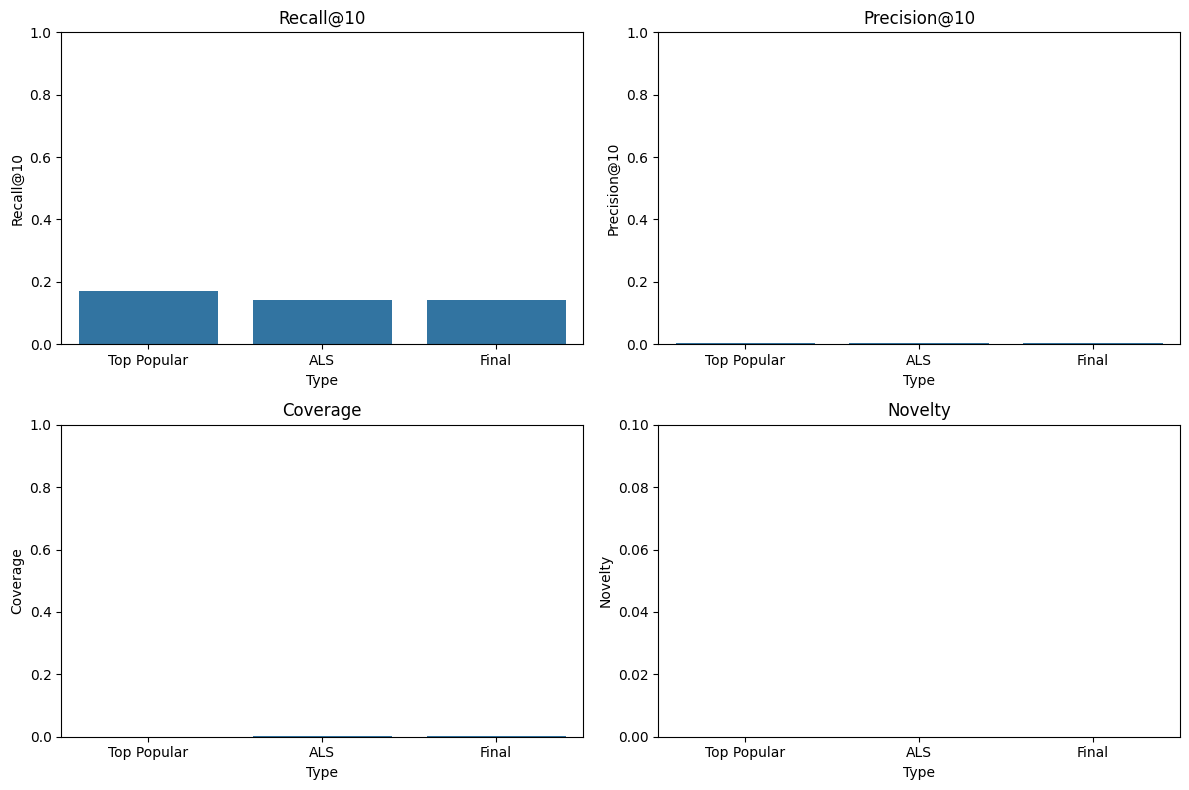

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
metrics = ['Recall@10', 'Precision@10', 'Coverage', 'Novelty']

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    sns.barplot(x='Type', y=metric, data=results_df)
    plt.title(metric)
    plt.ylim(0, 1 if metric != 'Novelty' else 0.1)
    
plt.tight_layout()
plt.savefig('recommendation_metrics_comparison.png')
plt.show()

# === Выводы, метрики ===

 Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.

## Проблемы данных:

Высокий уровень "холодных" пользователей (только 8273 из 783525 в персонализированных методах)
Возможно, смещение в тестовых данных


## Эффективность методов:


Топ популярных неожиданно показал лучший Recall
Персонализированные методы обеспечивают лучшее покрытие каталога
Процесс переранжирования не дал улучшений


## Пути улучшения:


Реализовать fallback-механизмы для холодных пользователей
Добавить контентные признаки в ранжирующую модель
Экспериментировать с другими алгоритмами (Word2Vec, Graph Neural Networks)
Внедрить A/B тестирование для валидации улучшений